# ベイズ推論による機械学習 第4章
混合モデルについて

In [116]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

import numpy as np
from scipy import stats
from PIL import Image, ImageDraw
from scipy.special import digamma as sp_digamma

In [3]:
IMG_PATH = "images/chapter_4/"

# ガウス混合分布

## ギブスサンプリング

In [4]:
np.random.rand()

0.663501094214558

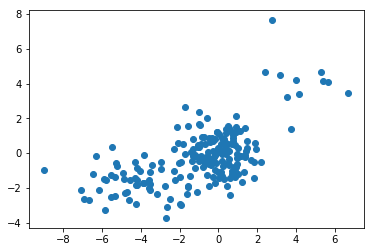

In [5]:
# 対象データ
N = 200
X = []
for i in range(N):
    rand = np.random.rand()
    if rand < 0.1:
        true_m = np.array([[4, 4]], dtype = 'float64')
        true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    elif rand < 0.4:
        true_m = np.array([[-4, -2]], dtype = 'float64')
        true_sigma = np.array([[3, 0], [0, 1]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    else:
        true_m = np.array([[0, 0]], dtype = 'float64')
        true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    X.append(x)
X = np.array(X) 
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [6]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.1:
            true_m = np.array([[4, 4]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.4:
            true_m = np.array([[-4, -2]], dtype = 'float64')
            true_sigma = np.array([[3, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

In [8]:
mu_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("mu_s", mu_s); print()

lam_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("lam_s", lam_s); print()

m_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("m_s", m_s); print()

beta = np.ones(3)
print("beta", beta); print()

nu_s = np.array([5, 5, 5])
print("nu_s", nu_s); print()

w_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("w_s", w_s); print()

pi = np.array([1/3, 1/3, 1/3])
print("pi", pi); print()

alpha = np.array([1, 1, 1])
print("alpha", alpha); print()

mu_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

lam_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

m_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

beta [1. 1. 1.]

nu_s [5 5 5]

w_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

pi [0.33333333 0.33333333 0.33333333]

alpha [1 1 1]



In [193]:
class GMM_GIBBS:
    '''混合ガウスモデルをギブスサンプリングで推定する
    '''
    def __init__(self, mu_s, lam_s, m_s, beta_s, nu_s, w_s, pi, alpha, max_iter=10):
        '''事前分布のベータの初期値を設定する
        inputs : mu_s, array(k * d),
                      lam_s, array(k * d * d), array(k, :, :) > 0
                      m_s, array(k * d)
                      beta_s, array(k), {beta_k > 0}
                      nu_s, array(k), {nu_k > d - 1}
                      w_s, array(k * d * d), array(k, :, :) > 0
                      pi, array(k), {pi_k > 0}, sum(pi_k) = 1
                      alpha, array(k), {alpha_k> 0}
                      max_iter, int, max_iter > 0
        '''
        # 初期値
        self.mu_s = np.array(mu_s)
        self.lam_s = np.array(lam_s)
        # gaussのパラメータ
        self.m_s = np.array(m_s)
        self.beta_s = np.array(beta_s)
        # wishartのパラメータ
        self.nu_s = np.array(nu_s)
        self.w_s = np.array(w_s)
        # cat and dirichletのパラメータ
        self.pi = np.array(pi)
        self.alpha = np.array(alpha)
        self.eta_s = np.array([])
        
        self.max_iter = max_iter
        self.K = self.mu_s.shape[0]
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * d),
        return : None
        '''
        sample_num = X.shape[0]
        for i in range(self.max_iter):
#             print(f"iter : {i}")
            ### Sのサンプリング
            S = []
            eta_s = []
            for j in range(sample_num):
                eta = []
                for k in range(self.K):
                    tmp = -1/2 * np.dot(np.dot((X[j] - self.mu_s[k]).reshape(1, -1), self.lam_s[k]),
                                                        (X[j]  - self.mu_s[k]).reshape(-1, 1))[0][0]
                    tmp += 1/2*np.log(np.linalg.det(self.lam_s[k]))
                    tmp += np.log(self.pi[k])
                    eta.append(np.exp(tmp))
                eta = np.array(eta)
                eta = np.array(eta) / np.sum(eta)
                eta_s.append(eta)
                S.append(np.random.multinomial(1, eta, size=1))
            S = np.array(S).reshape(-1, self.K)
            self.eta_s = np.array(eta_s)

            ### mu_s, lam_s, pi のサンプリング
            # pi
            alpha = self.alpha + np.sum(S, axis=0)
            self.pi = stats.dirichlet.rvs(alpha, size=1).reshape(self.K)
            
            # mu_s
            beta_s_old = np.array(self.beta_s)
            m_s_old = np.array(self.m_s)
            beta_s = self.beta_s + np.sum(S, axis=0)
            m_s = (np.dot(S.T, X) + np.dot(beta_s_old, m_s_old)) / beta_s.reshape(-1, 1)
            
            # lam_s
            nu_s = np.array(self.nu_s) + np.sum(S, axis=0)

            w_s = []
            lam_s = []
            mu_s = []
            for k in range(self.K):
                w_k_inv =  np.linalg.inv(self.w_s[k])
                w_k_inv += beta_s_old[k] * np.dot(m_s_old[k].reshape(-1, 1), m_s_old[k].reshape(1, -1))
                w_k_inv -= beta_s[k] * np.dot(m_s[k].reshape(-1, 1), m_s[k].reshape(1, -1))
                for j in range(sample_num):
                    w_k_inv += S[j, k] * np.dot(X[j].reshape(-1, 1), X[j].reshape(1, -1))
                w_k = np.linalg.inv(w_k_inv)
                w_s.append(w_k)
                lam_k = stats.wishart.rvs(df=nu_s[k], scale = w_k, size=1)
                lam_s.append(lam_k)
                mu_s.append(stats.multivariate_normal.rvs(m_s[k],
                                                                                              np.linalg.inv(lam_k)*(1/beta_s[k]),
                                                                                              size=1))
            self.lam_s = np.array(lam_s)
            self.mu_s = np.array(mu_s)


        # 事前パラメータを更新
        self.nu_s = nu_s
        self.w_s = np.array(w_s)
        self.m_s = m_s
        self.beta_s = beta_s
        self.alpha = alpha
        return

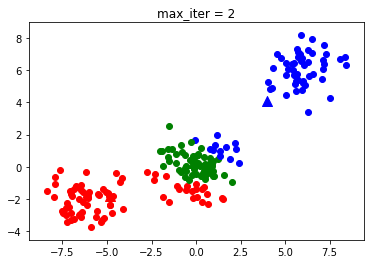

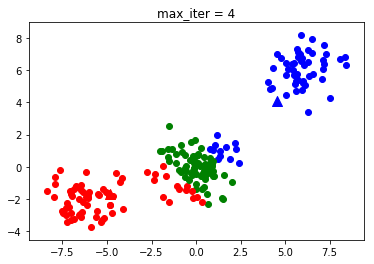

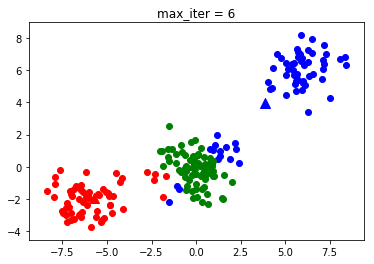

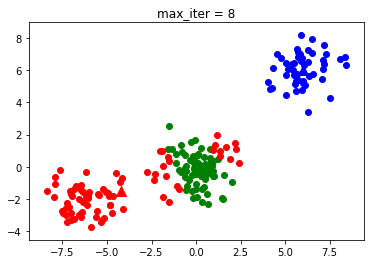

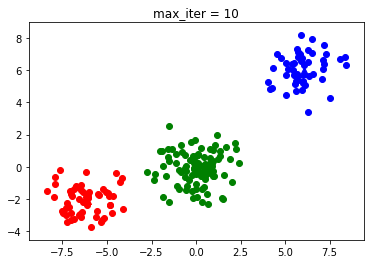

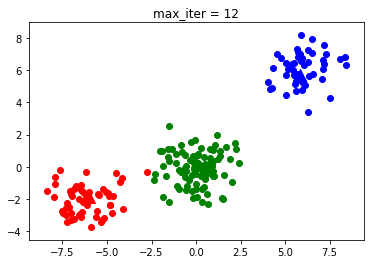

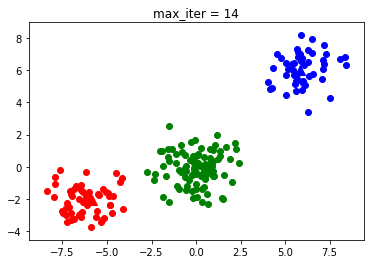

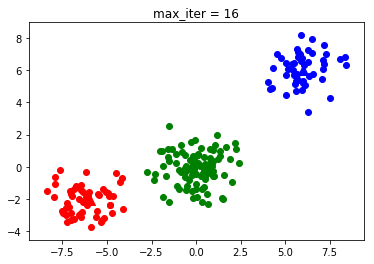

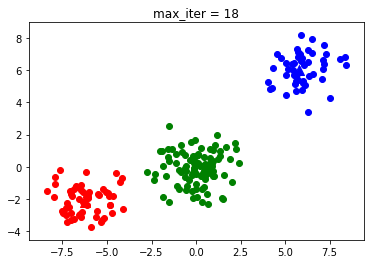

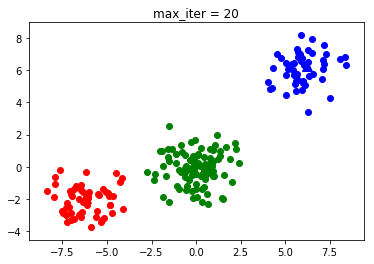

In [194]:
X = sample_gmm(200)

for max_iter in [2*(i+1)for i in range(10)]:
    gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_gbbs.fit(X)
    cluster = np.argmax(gmm_gbbs.eta_s, axis=1)
    colors = ["green", "blue", "red"]
    for k in range(mu_s.shape[0]):
        plt.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = colors[k], marker='^', s=100)
    
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=colors[cluster[i]])
    plt.title(f"max_iter = {max_iter}")
    plt.show()

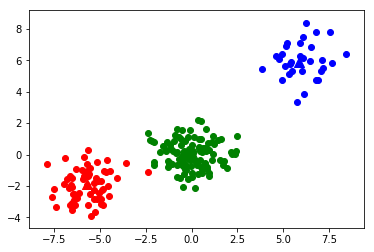

In [195]:
X = sample_gmm(200)
gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, 100)
gmm_gbbs.fit(X)
cluster = np.argmax(gmm_gbbs.eta_s, axis=1)
colors = ["green", "blue", "red"]
for k in range(mu_s.shape[0]):
    plt.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = colors[k], marker='^', s=100)

for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], color=colors[cluster[i]])
plt.show()

## 変分推論

In [112]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.2:
            true_m = np.array([[4, 4]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.5:
            true_m = np.array([[-4, -2]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

In [106]:
mu_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("mu_s", mu_s); print()

lam_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("lam_s", lam_s); print()

m_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("m_s", m_s); print()

beta = np.ones(3)
print("beta", beta); print()

nu_s = np.array([5, 5, 5])
print("nu_s", nu_s); print()

w_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("w_s", w_s); print()

pi = np.array([1/3, 1/3, 1/3])
print("pi", pi); print()

alpha = np.array([1, 1, 1])
print("alpha", alpha); print()

mu_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

lam_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

m_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

beta [1. 1. 1.]

nu_s [5 5 5]

w_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

pi [0.33333333 0.33333333 0.33333333]

alpha [1 1 1]



In [214]:
class GMM_VI:
    '''混合ガウスモデルを変分推論で推定する
    '''
    def __init__(self, mu_s, lam_s, m_s, beta_s, nu_s, w_s, pi, alpha, max_iter=10):
        '''事前分布のベータの初期値を設定する
        inputs : mu_s, array(k * d),
                      lam_s, array(k * d * d), array(k, :, :) > 0
                      m_s, array(k * d)
                      beta_s, array(k), {beta_k > 0}
                      nu_s, array(k), {nu_k > d - 1}
                      w_s, array(k * d * d), array(k, :, :) > 0
                      pi, array(k), {pi_k > 0}, sum(pi_k) = 1
                      alpha, array(k), {alpha_k> 0}
                      max_iter, int, max_iter > 0
        '''
        # 初期値
        self.mu_s = np.array(mu_s)
        self.lam_s = np.array(lam_s)
        # gaussのパラメータ
        self.m_s = np.array(m_s)
        self.beta_s = np.array(beta_s)
        # wishartのパラメータ
        self.nu_s = np.array(nu_s)
        self.w_s = np.array(w_s)
        # cat and dirichletのパラメータ
        self.pi = np.array(pi)
        self.alpha = np.array(alpha)
        self.ets_s = np.array([])
        
        self.max_iter = max_iter
        self.K = self.mu_s.shape[0]
        
        self.D = len(mu_s[0])
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * d),
        return : None
        '''
        # 更新するハイパラ
        m_s_hat = self.m_s
        beta_s_hat = self.beta_s
        nu_s_hat = self.nu_s
        w_s_hat = self.w_s
        alpha_hat = self.alpha
        eta_s_hat = np.array([])
        
        sample_num = X.shape[0]
        for i in range(self.max_iter):
            
            ### Sのハイパパラの更新
            eta_s = []
            for j in range(sample_num):
                eta = []
                for k in range(self.K):
                    tmp = -1/2 * nu_s_hat[k] * np.trace(np.dot(X[j].reshape(1, -1),
                                                                                                  np.dot(w_s_hat[k], X[j].reshape(-1, 1))))
                    tmp += nu_s_hat[k] * np.trace(np.dot(X[j].reshape(1, -1),
                                                                                        np.dot(w_s_hat[k], m_s_hat[k].reshape(-1, 1))))
                    tmp += -1/2 * nu_s_hat[k] * np.trace(np.dot(m_s_hat[k].reshape(1, -1),
                                                                                                   np.dot(w_s_hat[k], m_s_hat[k].reshape(-1, 1))))
                    tmp += -1/2 * self.D / beta_s_hat[k]
                    tmp += 1/2 * (self.D * np.log(2) + np.log(np.linalg.det(w_s_hat[k])))
                    for d in range(self.D):
                        tmp += 1/2 * sp_digamma((nu_s_hat[k]+d)/2)
                    tmp += sp_digamma(alpha_hat[k]) - sp_digamma(alpha_hat.sum())
                    eta.append(np.exp(tmp))
                eta = np.array(eta)
                eta = np.array(eta) / np.sum(eta)
                eta_s.append(eta)
            eta_s_hat = np.array(eta_s)
            
            ### mu_s, lam_s, pi のハイパラの更新
            # pi
            alpha_hat= self.alpha + np.sum(eta_s_hat, axis=0)
            
            # mu_s
            beta_s_hat = self.beta_s + np.sum(eta_s_hat, axis=0)
            m_s_hat = (np.dot(eta_s_hat.T, X) + np.dot(self.beta_s, self.m_s)) / beta_s_hat.reshape(-1, 1)
            
            # lam_s
            nu_s_hat = self.nu_s + np.sum(eta_s_hat, axis=0)

            w_s= []
            for k in range(self.K):
                w_k_inv =  np.linalg.inv(self.w_s[k])
                w_k_inv += self.beta_s[k] * np.dot(self.m_s[k].reshape(-1, 1), self.m_s[k].reshape(1, -1))
                w_k_inv -= beta_s_hat[k] * np.dot(m_s_hat[k].reshape(-1, 1), m_s_hat[k].reshape(1, -1))
                for j in range(sample_num):
                    w_k_inv += eta_s_hat[j, k] * np.dot(X[j].reshape(-1, 1), X[j].reshape(1, -1))
                w_s.append(np.linalg.inv(w_k_inv))
            w_s_hat = np.array(w_s)


        # 事前パラメータを更新
        self.nu_s = nu_s_hat
        self.w_s = w_s_hat
        self.m_s = m_s_hat
        self.beta_s = beta_s_hat
        self.alpha = alpha_hat
        self.eta_s = eta_s_hat
        
        # 事後分布からのサンプリング
        lam_s = []
        mu_s = []
        for k in range(self.K):
            lam_k = stats.wishart.rvs(df=self.nu_s[k], scale = self.w_s[k], size=1)
            lam_s.append(lam_k)
            mu_s.append(stats.multivariate_normal.rvs(self.m_s[k],
                                                                                            np.linalg.inv(lam_k)*(1/self.beta_s[k]),
                                                                                            size=1))
            
        self.pi = stats.dirichlet.rvs(self.alpha, size=1).reshape(self.K)
        self.mu_s = np.array(mu_s)
        self.lam_s = np.array(lam_s)
        return

[71.79594266 59.93700751 83.26704982]


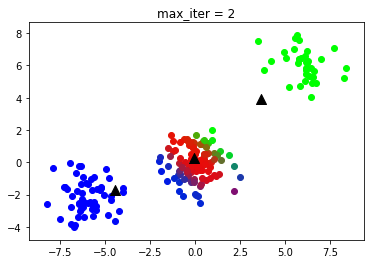

[89.17483379 47.83634665 77.98881956]


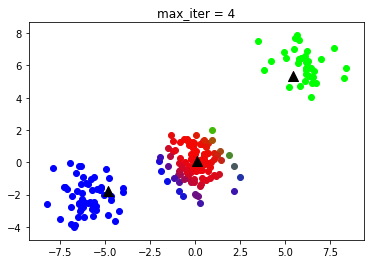

[102.66756007  41.4388613   70.89357863]


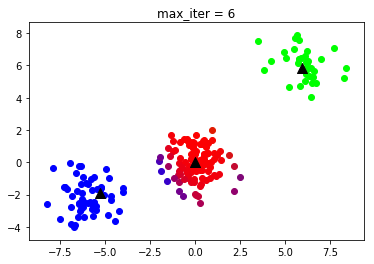

[111.03501857  41.00119929  62.96378214]


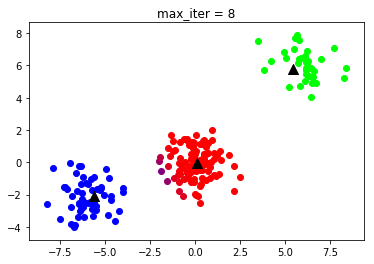

[113.91767603  41.0011266   60.08119737]


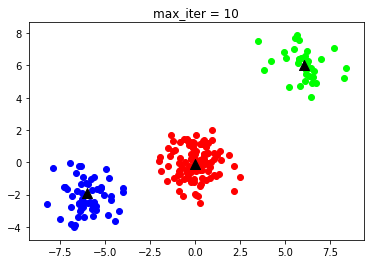

[113.96526052  41.00112652  60.03361295]


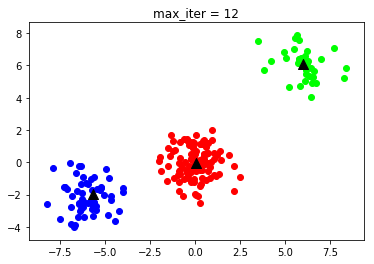

[113.9653972   41.00112653  60.03347628]


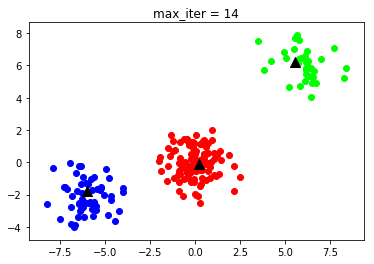

[113.96539758  41.00112653  60.0334759 ]


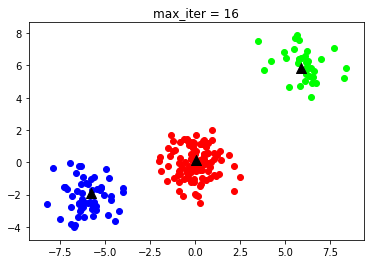

[113.96539758  41.00112653  60.0334759 ]


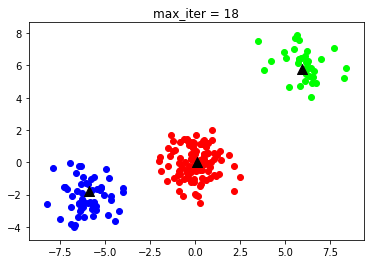

[113.96539758  41.00112653  60.0334759 ]


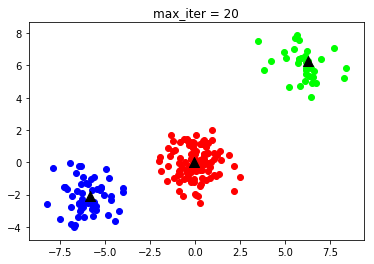

In [208]:
X = sample_gmm(200)
        
for max_iter in [2*(i+1)for i in range(10)]:
    gmm_vi = GMM_VI(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_vi.fit(X)
    cluster = np.argmax(gmm_vi.eta_s, axis=1)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=gmm_vi.eta_s[i])
    for k in range(mu_s.shape[0]):
        plt.scatter(gmm_vi.mu_s[k][0], gmm_vi.mu_s[k][1], color = "black", marker='^', s=100)
    plt.title(f"max_iter = {max_iter}")
    plt.show()

## 比較

In [203]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.2:
            true_m = np.array([[6, 6]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.5:
            true_m = np.array([[-6, -2]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

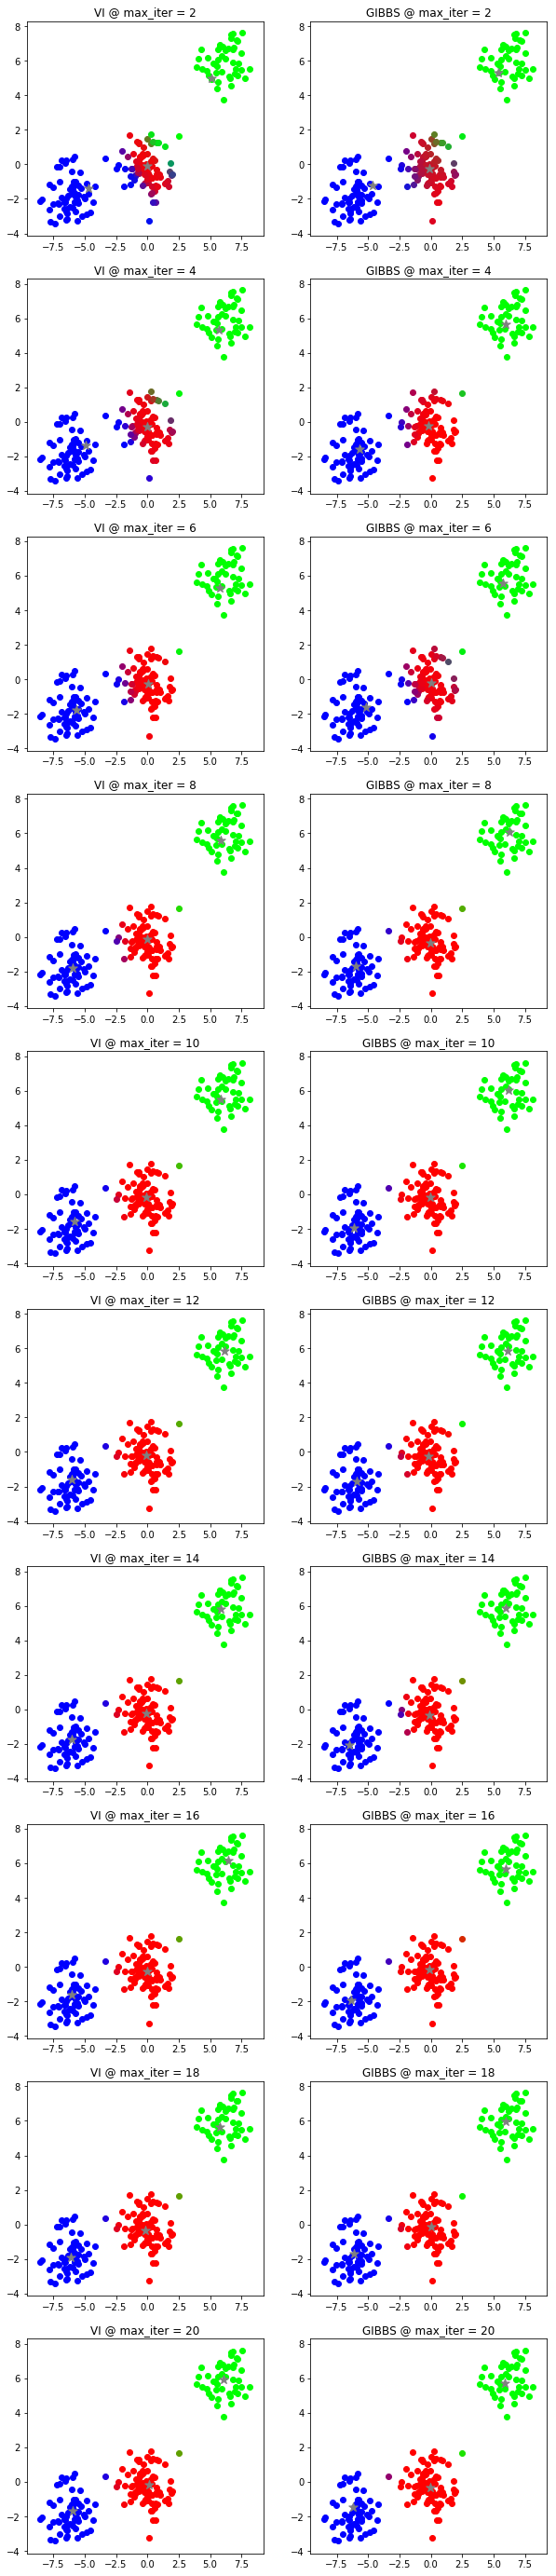

In [217]:
X = sample_gmm(200)

nrows=10
fig,axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, int(nrows*5)))
colors = ["red", "green", "blue"]

for j in range(nrows):
    max_iter = 2*(j+1)
    ### 変分推論
    gmm_vi = GMM_VI(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_vi.fit(X)
    # 結果の描画
    axe = axes[j, 0]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_vi.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_vi.mu_s[k][0], gmm_vi.mu_s[k][1], color = "gray", marker='*', s=100)
    axe.set_title(f"VI @ max_iter = {max_iter}")
    
    ### ギブスサンプリング
    gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_gbbs.fit(X)
    # 結果の描画
    axe = axes[j, 1]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_gbbs.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = "gray", marker='*', s=100)
    axe.set_title(f"GIBBS @ max_iter = {max_iter }")

plt.show()

In [218]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.2:
            true_m = np.array([[4, 4]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.5:
            true_m = np.array([[-4, -2]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 3]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

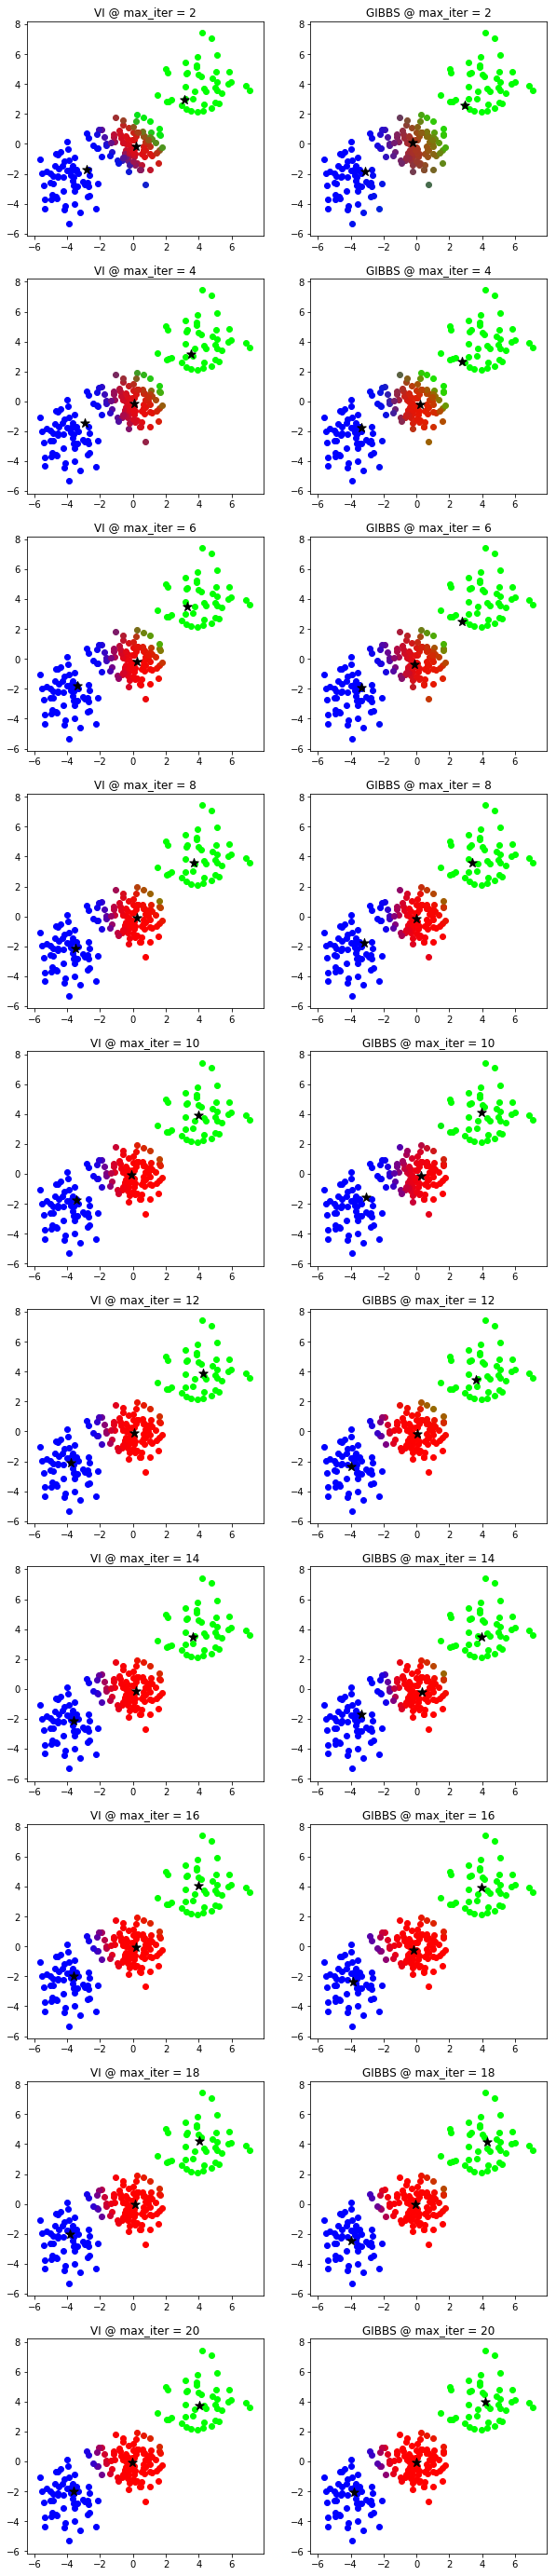

In [219]:
X = sample_gmm(200)

nrows=10
fig,axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, int(nrows*5)))
colors = ["red", "green", "blue"]

for j in range(nrows):
    max_iter = 2*(j+1)
    ### 変分推論
    gmm_vi = GMM_VI(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_vi.fit(X)
    # 結果の描画
    axe = axes[j, 0]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_vi.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_vi.mu_s[k][0], gmm_vi.mu_s[k][1], color = "black", marker='*', s=100)
    axe.set_title(f"VI @ max_iter = {max_iter}")
    
    ### ギブスサンプリング
    gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_gbbs.fit(X)
    # 結果の描画
    axe = axes[j, 1]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_gbbs.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = "black", marker='*', s=100)
    axe.set_title(f"GIBBS @ max_iter = {max_iter }")

plt.show()

In [220]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.1:
            true_m = np.array([[4, 4]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.45:
            true_m = np.array([[-4, -2]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 3]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

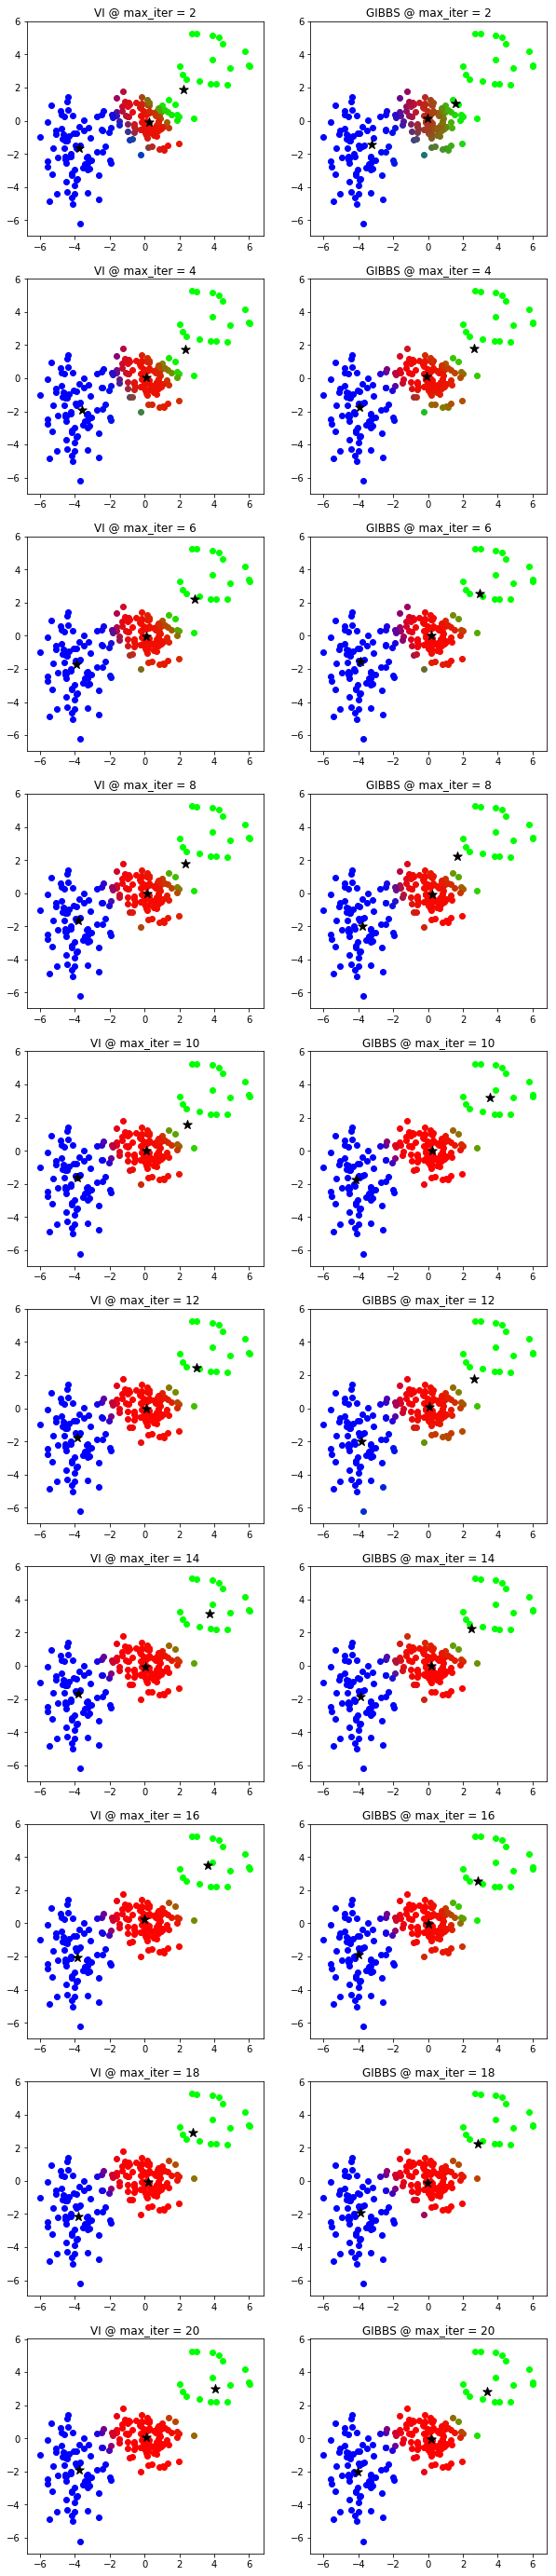

In [221]:
X = sample_gmm(200)

nrows=10
fig,axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, int(nrows*5)))
colors = ["red", "green", "blue"]

for j in range(nrows):
    max_iter = 2*(j+1)
    ### 変分推論
    gmm_vi = GMM_VI(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_vi.fit(X)
    # 結果の描画
    axe = axes[j, 0]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_vi.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_vi.mu_s[k][0], gmm_vi.mu_s[k][1], color = "black", marker='*', s=100)
    axe.set_title(f"VI @ max_iter = {max_iter}")
    
    ### ギブスサンプリング
    gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    gmm_gbbs.fit(X)
    # 結果の描画
    
    axe = axes[j, 1]
    for i in range(X.shape[0]):
        axe.scatter(X[i, 0], X[i, 1], color=gmm_gbbs.eta_s[i])
    for k in range(mu_s.shape[0]):
        axe.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = "black", marker='*', s=100)
    axe.set_title(f"GIBBS @ max_iter = {max_iter }")

plt.show()